In [63]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt


In [43]:
df = pd.read_csv("anuario_producion_agricola_nacional_2019-2022.csv")

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7592 entries, 0 to 7591
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Región       7592 non-null   object
 1   Año          7592 non-null   int64 
 2   Cultivo      7592 non-null   object
 3   rendimiento  7592 non-null   object
 4   siembras     7592 non-null   object
 5   cosecha      7592 non-null   object
 6   precio       7592 non-null   object
 7   produccion   7592 non-null   object
dtypes: int64(1), object(7)
memory usage: 474.6+ KB


In [45]:
columns = ['rendimiento', 'siembras', 'cosecha', 'precio', 'produccion']
for col in columns:
    df[col] = df[col].replace('-', 0)

In [46]:
df = df.astype({
    'Cultivo': 'category',
    'Región': 'category',
    'Año': 'int32',
    'rendimiento':'float64',
    'precio':'float64',
    'produccion':'float64',
    'siembras':'float64',
    'cosecha':'float64'
})

In [47]:
df.head(3)

,Región,Año,Cultivo,rendimiento,siembras,cosecha,precio,produccion
0,Amazonas,2021,Acelga,3700.000000,2.5,2.5,0.979459,9.25
1,Áncash,2021,Acelga,8517.647059,86.0,85.0,1.487431,724.00
2,Apurímac,2021,Acelga,0.000000,0.0,0.0,0.000000,0.00


In [48]:
# data = pd.get_dummies(data=df ,columns=['Región', 'Año', 'Cultivo'], dtype=int)
#X = data.drop('precio', axis=1)
#Y = data['precio']

In [49]:
df.dtypes

Región         category
Año               int32
Cultivo        category
rendimiento     float64
siembras        float64
cosecha         float64
precio          float64
produccion      float64
dtype: object

In [50]:
cat_cols = ['Región', 'Cultivo']
num_cols = ['rendimiento', 'siembras', 'cosecha', 'produccion', "Año"]

In [ ]:
encoder = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
X_cat = encoder.fit_transform(df[cat_cols])
X_num = df[num_cols].to_numpy()

X = hstack([X_cat, X_num])

In [52]:
y = df['precio'].values

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,     # 20% test
    random_state=42,   # reproducibility
    shuffle=True
)

### ML

In [54]:
regr = RandomForestRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'min_samples_leaf': [1, 4, 8, 16, 32],
    'max_leaf_nodes': [None, 20, 50, 100],
}

In [55]:
grid = GridSearchCV(
    estimator=regr,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',   # or 'r2'
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)

,estimator,RandomForestR...ndom_state=42)
,param_grid,"{'max_leaf_nodes': [None, 20, ...], 'min_samples_leaf': [1, 4, ...], 'n_estimators': [50, 100, ...]}"
,scoring,'neg_mean_squared_error'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_estimators,100


In [56]:

print("Best parameters:", grid.best_params_)
print("Best CV score:", -grid.best_score_)

Best parameters: {'max_leaf_nodes': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV score: 0.1851628863872952


In [59]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)


In [60]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # same as mean_squared_error(..., squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("MAE:", mae)
print("R²:", r2)

MSE: 0.19746065619090225
RMSE: 0.4443654534174571
MAE: 0.17401495338455075
R²: 0.901306743598299


In [62]:
y_train_pred = best_model.predict(X_train)

print("Train R²:", r2_score(y_train, y_train_pred))
print("Test R²:", r2_score(y_test, y_pred))

Train R²: 0.9876177184227225
Test R²: 0.901306743598299


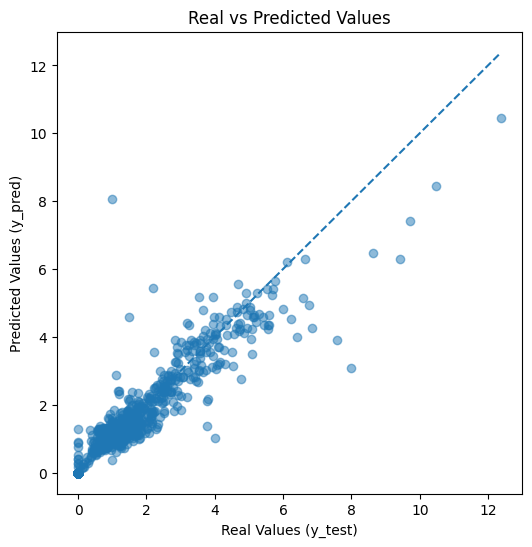

In [64]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle='--')
plt.xlabel("Real Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Real vs Predicted Values")
plt.show()

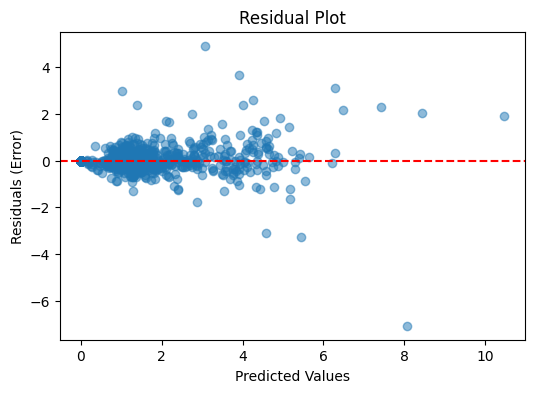

In [65]:
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Error)")
plt.title("Residual Plot")
plt.show()